# Semantic segmentation

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from os import listdir
import re

from PIL import Image

### Read in data

In [3]:
# get all file names
path = 'generator'
files = [f for f in listdir(path) if f[-4:]=='.png']
# load one to get the dimensions
image = mpimg.imread(f'{path}/{files[0]}')
# get dimensions
shape = list(image.shape)
# remove alpha if necessary
if (shape[2]==4):
    shape[2] = 3
n = len(files)
n

1000

Decipher label legend

In [25]:
a = re.search('^([0-9]*)_([0-9]*)_([0-9]*)',files[1])
b = np.zeros(3)
b[:] = a[1],a[2],a[3]
b

array([17., 24., 17.])

In [26]:
y = np.zeros(shape=(n,3),dtype=int)
X = np.zeros(shape=(n,*shape))
for i in range(len(files)):
    # get the hour from the file name
    yy = re.search('^([0-9]*)_([0-9]*)_([0-9]*)',files[i])
    y[i,:] = yy[1],yy[2],yy[3]
    X[i] = (mpimg.imread(f'{path}/{files[i]}')[:,:,:shape[2]] )

In [1]:
# generate labeled image from legend
def segment(x,y):
    a,b,c = y
    output = np.zeros(shape=x.shape[:2],dtype=int)
    ii,jj = x.shape[:2]
    for i in range(ii):
        for j in range(jj):
            if (i-a)**2+(j-b)**2<=(c)**2:
                output[j,i] = 1  
    return output

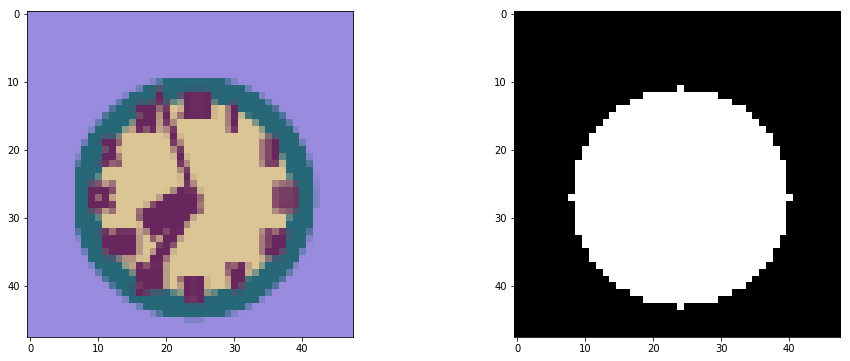

In [112]:
# sample input and label
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
i = np.random.randint(0,n)
ax[0].imshow(X[i])
ax[1].imshow(segment(X[i],y[i]),cmap='gray')
plt.show()

### Generate model

In [146]:
from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Conv2DTranspose, Dense, Reshape

In [159]:
input_layer = Input(shape=(X.shape[1:]))
conv1 = Convolution2D(16, kernel_size=3, padding='same',activation='relu')(input_layer)
pool1 = MaxPooling2D()(conv1)

conv2 = Convolution2D(32, kernel_size=3, padding='same',activation='relu')(pool1)
pool2 = MaxPooling2D()(conv2)

conv3 = Convolution2D(64, kernel_size=3, padding='same',activation='relu')(pool2)
pool3 = MaxPooling2D()(conv3)

dense = Dense(6*6*64,activation='relu')(Flatten()(pool3))
reshape = Reshape(target_shape=(6,6,64))(dense)


convT1 = Conv2DTranspose(32, 3, strides=(2,2), padding='same',activation='relu')(reshape)

convT2 = Conv2DTranspose(16, 3, strides=(2,2), padding='same',activation='relu')(convT1)

convT3 = Conv2DTranspose(1, 3, strides=(2,2), padding='same',activation='sigmoid')(convT2)


model = Model(inputs=input_layer, outputs=convT3)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 6, 6, 64)          0         
__________

In [115]:
y_true = np.zeros(shape=[*X.shape[:-1],1])
for i in range(len(y_true)):
    y_true[i] = segment(X[i],y[i]).reshape(y_true.shape[1:])

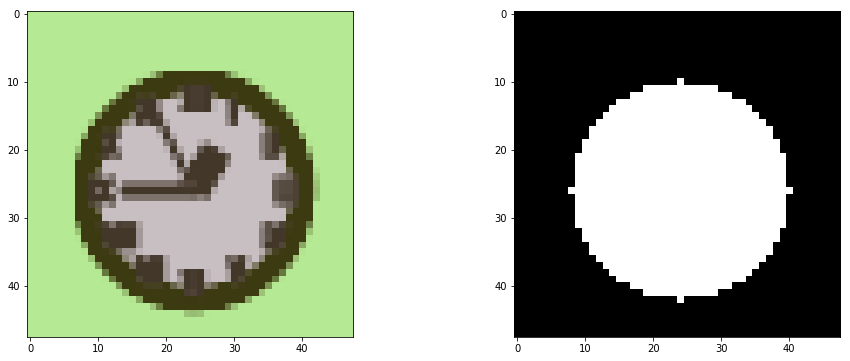

In [120]:
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
i = np.random.randint(0,n)
ax[0].imshow(X[i])
ax[1].imshow(y_true[i].reshape(48,48),cmap='gray')
plt.show()

### Train model

In [160]:
model.fit(X,y_true,epochs=10)

Epoch 1/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5063 - acc: 0.7495
Epoch 2/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3632 - acc: 0.8296
Epoch 3/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3388 - acc: 0.8412
Epoch 4/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.1336 - acc: 0.9449
Epoch 5/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0734 - acc: 0.9688
Epoch 6/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0604 - acc: 0.9742
Epoch 7/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0531 - acc: 0.9775
Epoch 8/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0457 - acc: 0.9805
Epoch 9/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0412 - acc: 0.9826
Epoch 10/10
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0339 - acc: 0.9857


In [161]:
model.evaluate(X,y_true)

1000/1000 [==============================] - 1s 1ms/step


[0.03481433433294296, 0.9843919258117676]

### Read in test-set and evaluate

In [123]:
path = 'test'
files = [f for f in listdir(path) if f[-4:]=='.png']
# load one to get the dimensions
image = mpimg.imread(f'{path}/{files[0]}')
# get dimensions
shape = list(image.shape)
# remove alpha if necessary
if (shape[2]==4):
    shape[2] = 3

y_t = np.zeros(shape=(n,3),dtype=int)
X_t = np.zeros(shape=(n,*shape))
for i in range(len(files)):
    # get the hour from the file name
    yy = re.search('^([0-9]*)_([0-9]*)_([0-9]*)',files[i])
    y_t[i,:] = yy[1],yy[2],yy[3]
    X_t[i] = (mpimg.imread(f'{path}/{files[i]}')[:,:,:shape[2]] )

y_test = np.zeros(shape=[*X_t.shape[:-1],1])
for i in range(len(y_test)):
    y_test[i] = segment(X_t[i],y_t[i]).reshape(y_test.shape[1:])

In [162]:
model.evaluate(X_t,y_test)

1000/1000 [==============================] - 1s 1ms/step


[0.037954168498516086, 0.9832951426506042]

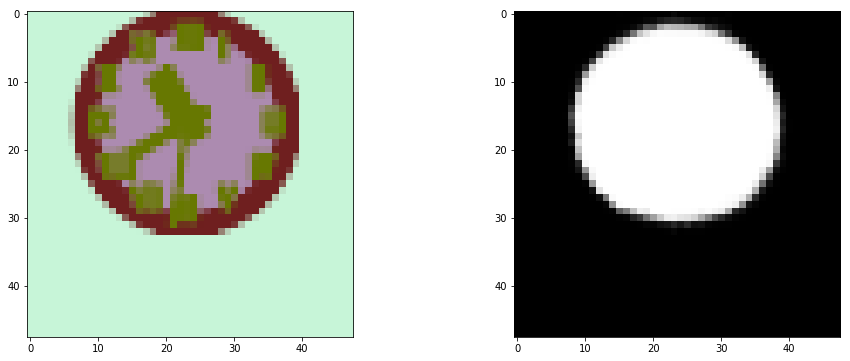

In [168]:
fig, ax = plt.subplots(ncols=2,figsize=(16,6))
i = np.random.randint(0,n)
ax[0].imshow(X_t[i])
pred = model.predict(X_t[i:i+1])
ax[1].imshow(pred.reshape(48,48),cmap='gray')
plt.show()